## Imports

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

import gymnasium as gym

import torch
from transformers import LlamaForCausalLM, AutoTokenizer

from dicl import dicl

/mnt/vdb/athomas/miniconda3/envs/dicl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load LLM model and tokenizer

* You need to have an account on [huggingface](https://huggingface.co/) and request access to the Llama models.
* The tokenizers that are supported are those who assign a separate token to each number between 0 and 999. This includes Llama 3, Llama 3.1, and Llama 3.2 families of models.

In [3]:
from huggingface_hub import login
login(token="your_hf_token")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /home/athomas/.cache/huggingface/token
Login successful


In [8]:
llm_model = "meta-llama/Llama-3.2-1B"

tokenizer = AutoTokenizer.from_pretrained(
    llm_model,
    use_fast=False,
)
model = LlamaForCausalLM.from_pretrained(
    llm_model,
    device_map="auto",
    torch_dtype=torch.bfloat16,
)
model.eval()

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm):

## Load data

* We will be using expert trajectories from the HalfCheetah Mujoco environment for our demo. The dataset is provided in `src/dicl/data/`.

In [25]:
env_name = "HalfCheetah"
env = gym.make(env_name + "-v4")
n_actions = env.action_space.shape[0]
n_observations = env.observation_space.shape[0]
data_label = "expert"
data_path = Path("src") / "dicl" / "data" / f"D4RL_{env_name}_{data_label}.csv"

# ICL parameters
context_length = 300
rescale_factor = 7.0
up_shift = 1.5

* Pick DICL(s) or DICL(s,a) method through the number of features (choose `n_observations` for vICL).

In [10]:
# to use DICL-(s) or vICL, set include_actions to False.
# to use DICL-(s,a), set include_actions to True
include_actions = True
if include_actions:
    n_features = n_observations + n_actions
else:
    n_features = n_observations

* Sample an episode and extract an in-context trajectory `(n_timestamps, n_features)`

In [14]:
# load data to get a sample episode
X = pd.read_csv(data_path, index_col=0)
X = X.values.astype("float")

# find episodes beginnings. the restart column is equal to 1 at the start of
# an episode, 0 otherwise.
restart_index = n_observations + n_actions + 1
restarts = X[:, restart_index]
episode_starts = np.where(restarts)[0]

# sample an episode and extract time series
episode = np.random.choice(episode_starts)
time_series = X[episode : episode + context_length, :n_features]

print(
    f"The in-context trajectory shape is (n_timestamps:{time_series.shape[0]}, "
    f"n_features:{time_series.shape[1]})"
)

The in-context trajectory shape is (n_timestamps:300, n_features:23)


## DICL

* Instantiate DICL
* Choose the number of components for PCA (set to half here)
* Dor vICL n_components has to be equal to n_features

In [17]:
# ------- For DICL-PCA -------
DICL = dicl.DICL_PCA(
    n_features=n_features,
    n_components=int(n_features / 2),
    model=model,
    tokenizer=tokenizer,
    rescale_factor=rescale_factor,
    up_shift=up_shift,
)
# ------- For vICL -------
# DICL = dicl.vICL(
#     n_features=n_features,
#     model=model,
#     tokenizer=tokenizer,
#     rescale_factor=rescale_factor,
#     up_shift=up_shift,
# )

* Fit disentangler (PCA here). This can be done using a bigger dataset than the in-context time series.

In [18]:
DICL.fit_disentangler(X=time_series)

### Single-step prediction and visualization

In [19]:
mean, mode, lb, ub = DICL.predict_single_step(X=time_series)

# print metrics
burnin = 0
single_step_metrics = DICL.compute_metrics(burnin=burnin)
print(f"after burnin steps: {burnin}")
print(
    "average_agg_squared_error: "
    f"{single_step_metrics['average_agg_squared_error']:.3f}"
)
print(f"agg_ks: {single_step_metrics['agg_ks']}")

after burnin steps: 0
average_agg_squared_error: 13.472
agg_ks: 0.09447142649411082


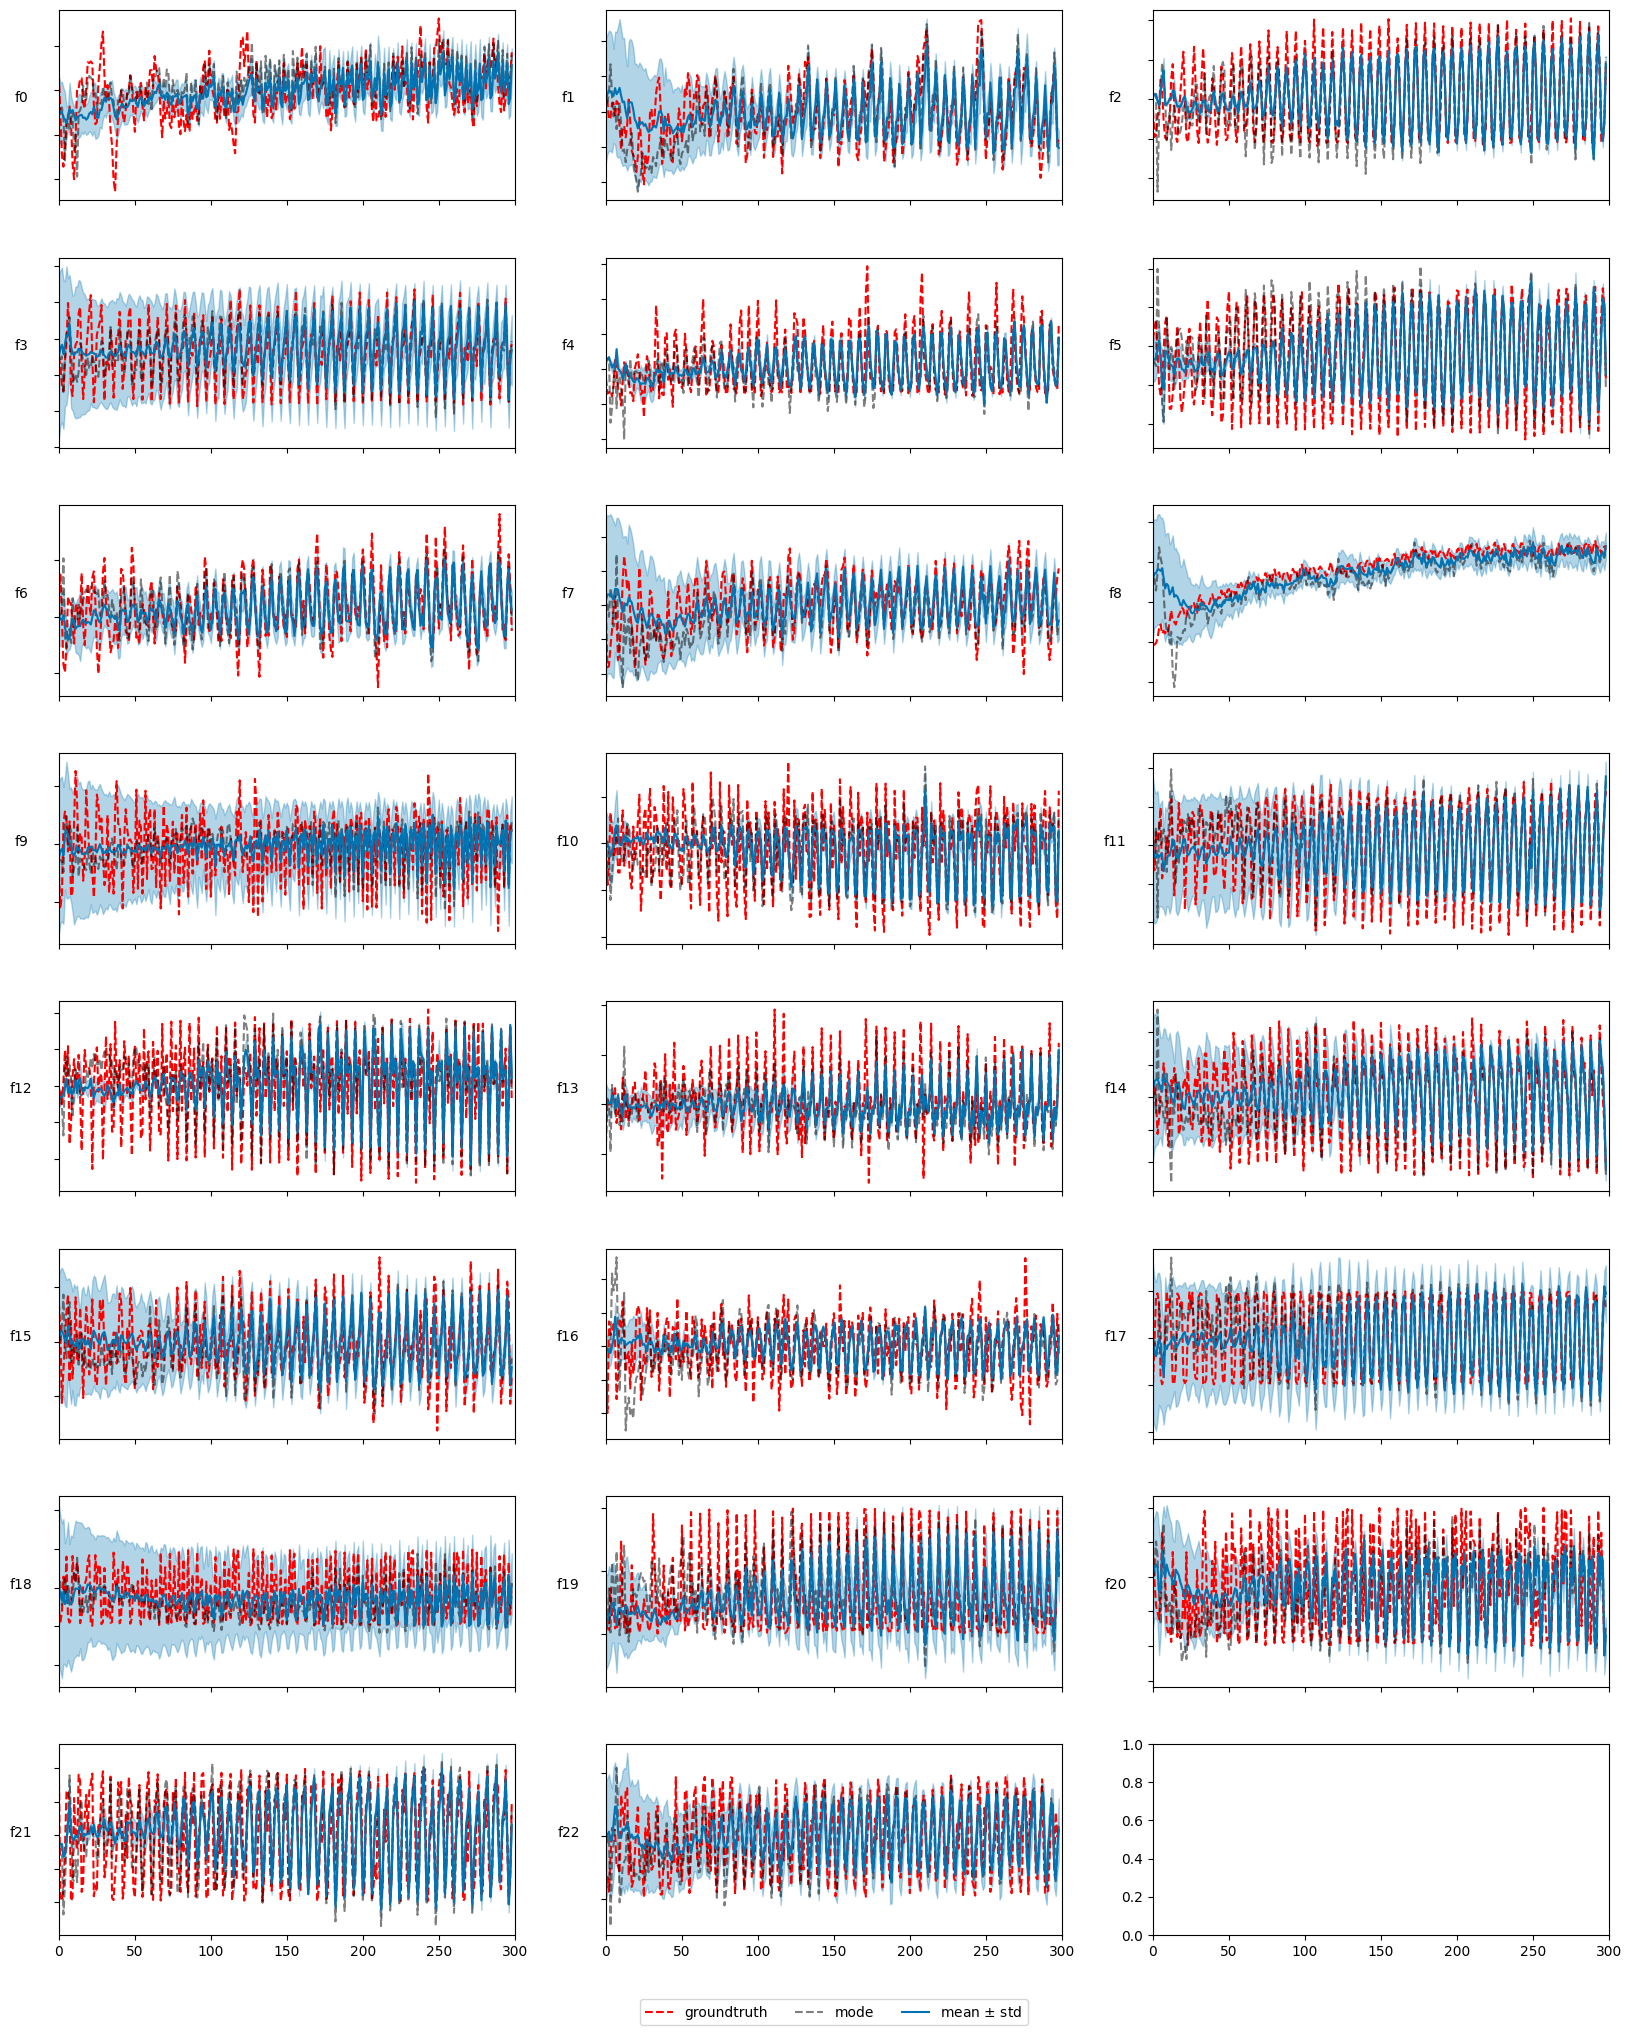

In [20]:
DICL.plot_single_step(xlim=[0, context_length])

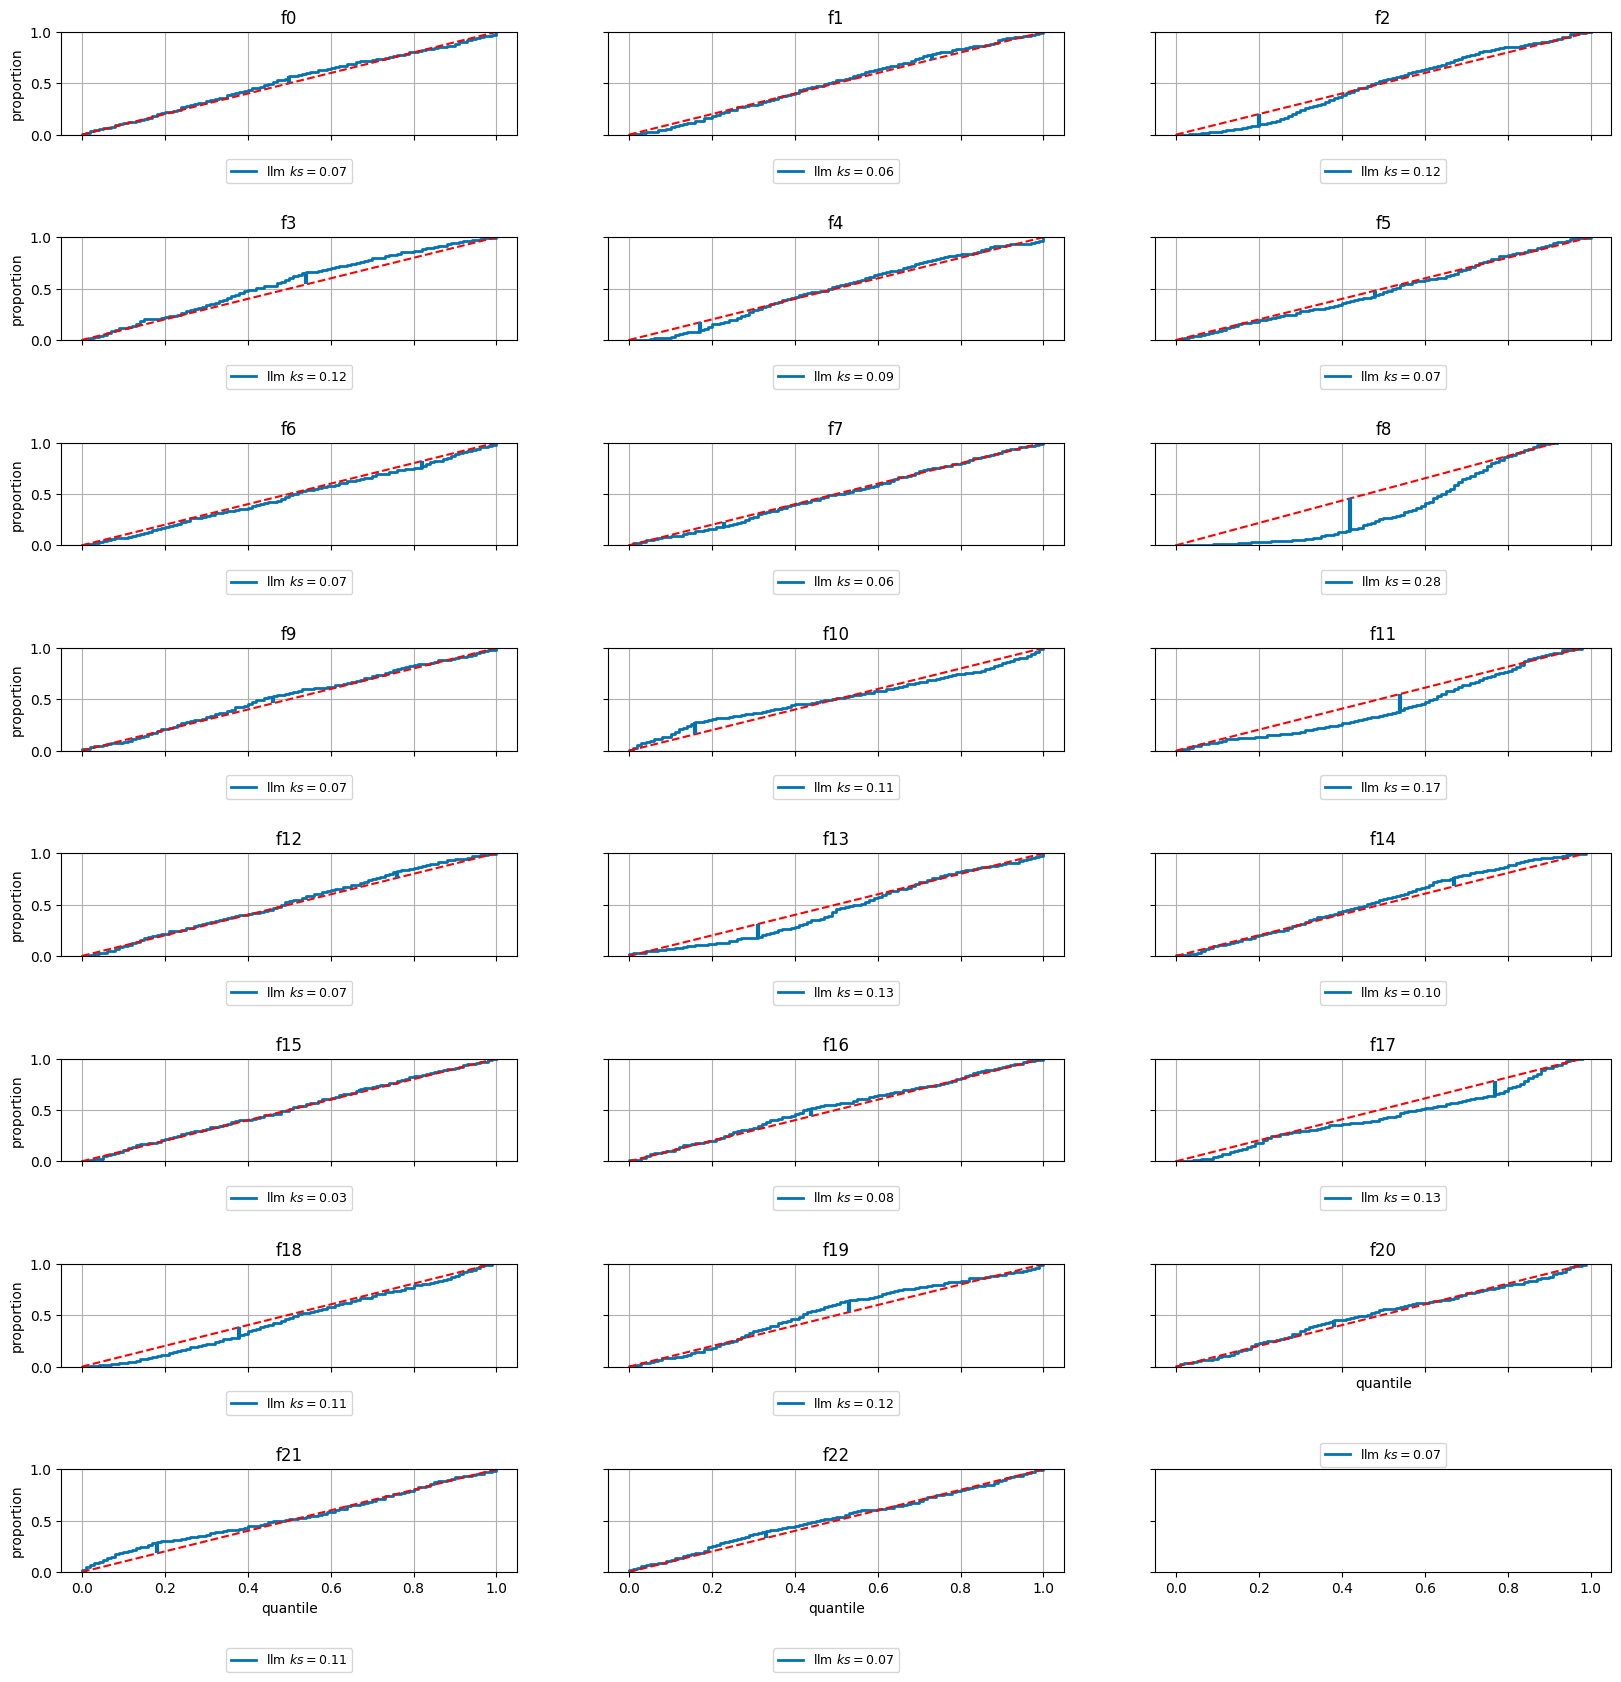

In [21]:
DICL.plot_calibration(burnin=0)

### Autoregressive multi-step prediction and visualization

In [22]:
prediction_horizon = 20
mean, mode, lb, ub = DICL.predict_multi_step(
    X=time_series,
    prediction_horizon=prediction_horizon,
    stochastic=True,
    if_true_mean_else_mode=True,
)

prediction_horizon: 100%|██████████| 20/20 [01:31<00:00,  4.60s/it]


In [23]:
# print metrics
burnin = context_length - prediction_horizon  # only keeps multi-step prediction
single_step_metrics = DICL.compute_metrics(burnin=burnin)
print(f"after burnin steps: {burnin}")
print(
    "average_agg_squared_error: "
    f"{single_step_metrics['average_agg_squared_error']:.3f}"
)
print(f"agg_ks: {single_step_metrics['agg_ks']}")

after burnin steps: 280
average_agg_squared_error: 14.521
agg_ks: 0.3313272311212815


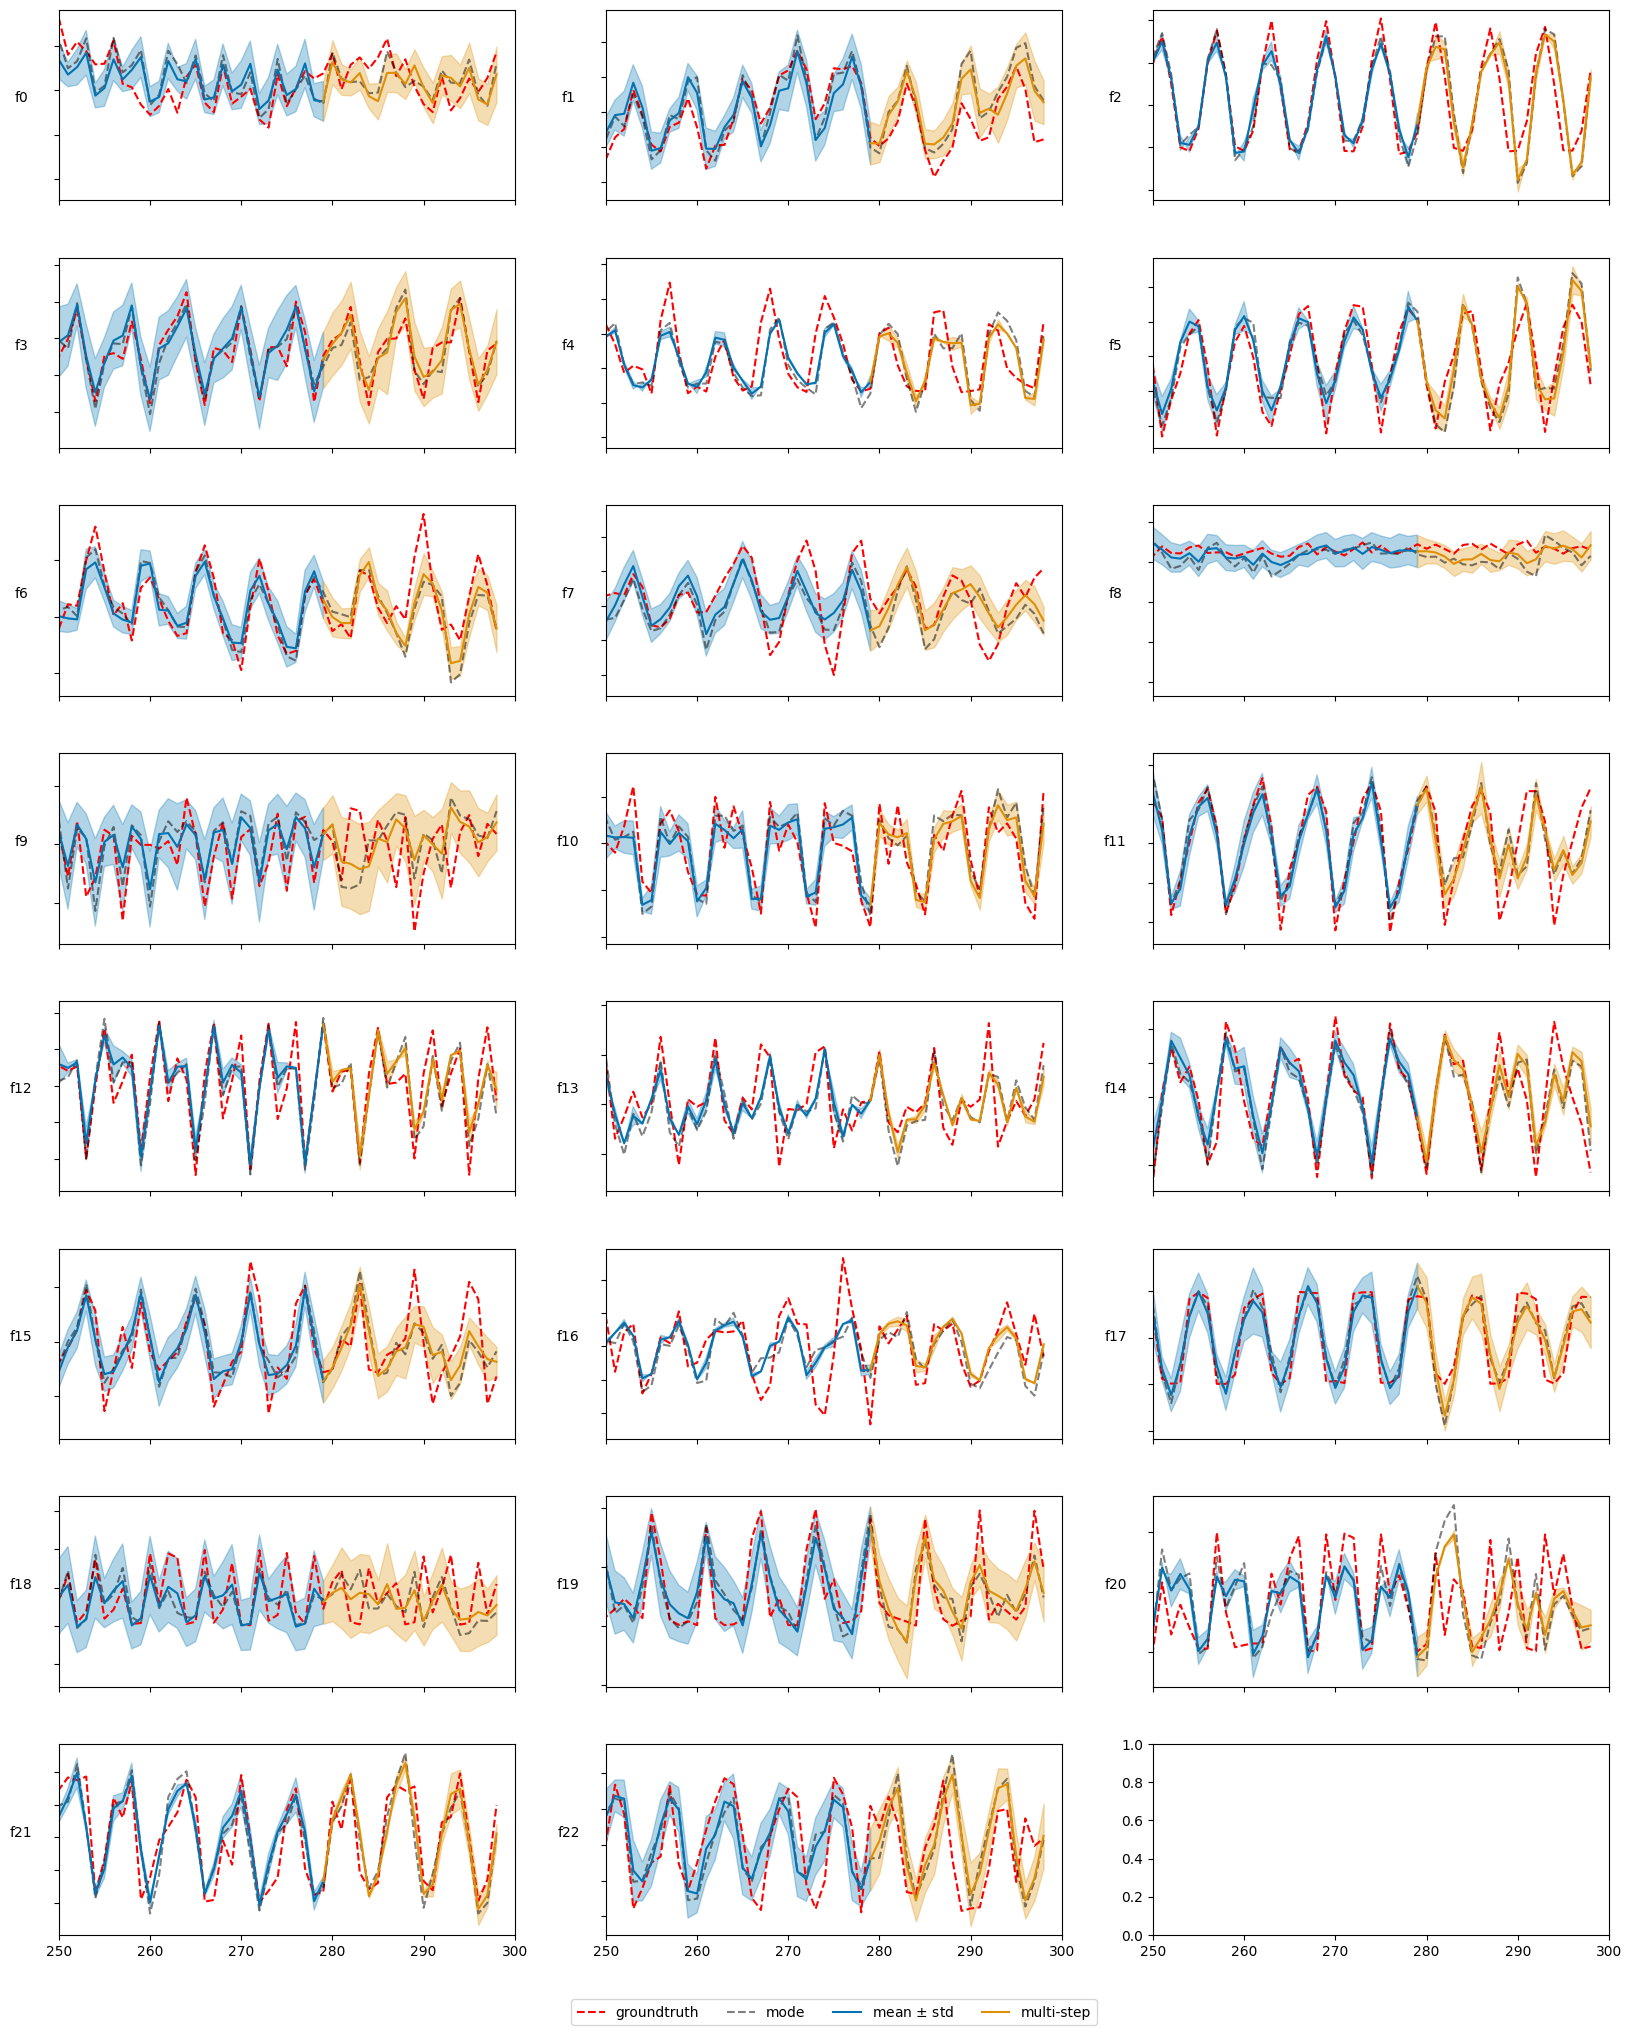

In [24]:
DICL.plot_multi_step(xlim=[context_length - 50, context_length])